In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import csv
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import requests
plt.style.use('fivethirtyeight')
%matplotlib inline

/Users/Esh/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/Esh/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#Scrape data (thanks 538!)
link = requests.get('http://projects.fivethirtyeight.com/election-2016/delegate-targets/democrats/').text
soup = BeautifulSoup(link)
table = soup.html.body.table
rows = table.tbody.find_all('tr')
data = []
for row in rows:
    cols = row.find_all('td')
    cols = [elem.text.strip() for elem in cols if elem]
    data.append(cols)

/Users/Esh/anaconda/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [3]:
#Convert to data frame and clean up
D = pd.DataFrame(data,columns = ['Date','State','Total','Clinton','Sanders'])
D['Clinton'] = D['Clinton'].apply(lambda x: x.split('/')[0])
D['Sanders'] = D['Sanders'].apply(lambda x: x.split('/')[0])
D = D.applymap(lambda x: np.nan if not x else x)
D['Date'] = D['Date'].fillna(method='ffill').apply(lambda x: x.replace('Feb.','February') if 'Feb' in x else x) + ' 2016'
D[['Total','Clinton','Sanders']] = D[['Total','Clinton','Sanders']].astype(float)
#Handle Missouri like the NYT
D.set_value(25,'Total',64)
D.set_value(25,'Clinton',32)
D.set_value(25,'Sanders',32)

,Date,State,Total,Clinton,Sanders
0,February 1 2016,Iowa,44,23,21
1,February 9 2016,New Hampshire,24,9,15
2,February 20 2016,Nevada,35,20,15
3,February 27 2016,South Carolina,53,39,14
4,March 1 2016,Alabama,53,44,9
5,March 1 2016,American Samoa,6,4,2
6,March 1 2016,Arkansas,32,22,10
7,March 1 2016,Colorado,66,28,38
8,March 1 2016,Georgia,102,74,28
9,March 1 2016,Massachusetts,91,46,45


In [4]:
#Computer some diffs and a regression line
D['Diff'] = D['Clinton'] - D['Sanders']
D[['CumTotal','CumClinton','CumSanders']] = D[['Total','Clinton','Sanders']].cumsum()
D['CumDiff'] = D['CumClinton'] - D['CumSanders']
totalDelegates = D['CumTotal'].max()
D['PercClinton'] = D['CumClinton'].apply(lambda x: x/totalDelegates*100)
D['PercSanders'] = D['CumSanders'].apply(lambda x: x/totalDelegates*100)
D['PercDiff'] = D['CumDiff']/totalDelegates*100
D['NormPercDiff'] = D['Diff']/D['Total']*100
D['NormClinton'] = D['Clinton']/D['Total']*100
D['NormSanders'] = D['Sanders']/D['Total']*100

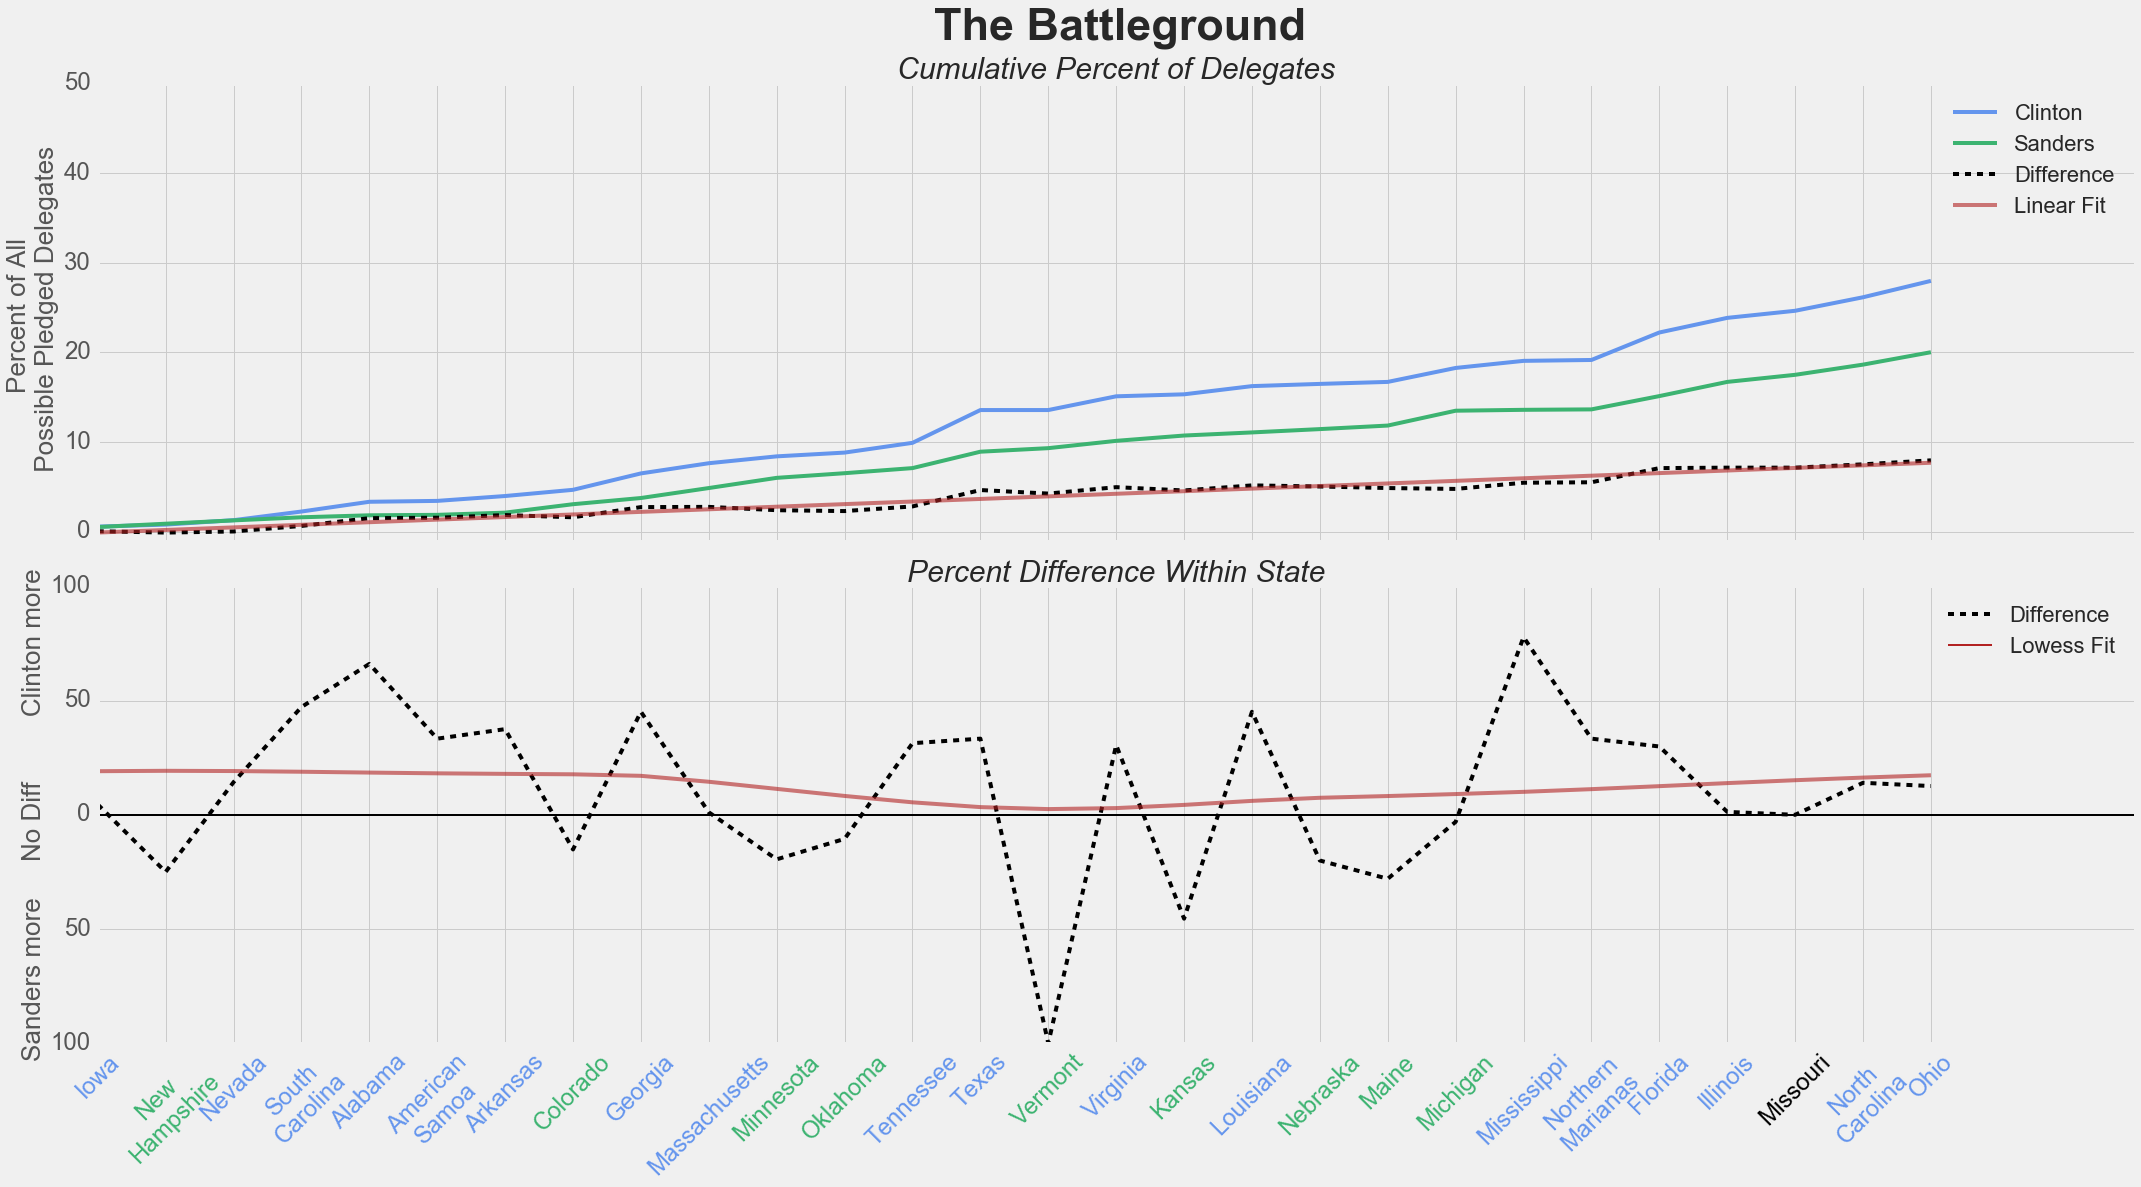

In [576]:
toNow = D[[time.localtime() > time.strptime(elem,'%B %d %Y') for elem in D['Date']]]
diffs = toNow.ix[:,'PercDiff'].values
slope, intercept = np.polyfit(range(len(diffs)),diffs,1)
fits = slope * np.arange(len(diffs)) + intercept
normdiffs = toNow.ix[pd.notnull(toNow['NormPercDiff']),'NormPercDiff'].values


fig, axes = plt.subplots(2,1, figsize=(30,16),sharex=True)

axes[0].plot(toNow.index,toNow['PercClinton'],'cornflowerblue',
         toNow.index,toNow['PercSanders'],'mediumseagreen',
         toNow.index,toNow['PercDiff'],'k--', linewidth=4);
axes[0].plot(np.arange(len(diffs)),fits,'firebrick',alpha=.6);
axes[0].yaxis.set_tick_params(labelsize=24);
axes[0].set_ylabel('Percent of All \n Possible Pledged Delegates',fontsize=26);
axes[0].set_ylim([-1,50]);
axes[0].legend(('Clinton','Sanders','Difference','Linear Fit'),fontsize=22);
axes[0].set_title('Cumulative Percent of Delegates',fontsize=30,style='italic')

axes[1].plot(toNow.index,toNow['NormPercDiff'],'k--', linewidth=4);
axes[1].axhline(color='black',linewidth=2);
sns.regplot(x=np.arange(len(diffs)),y=normdiffs,ax=axes[1],scatter=False,lowess=True,color='firebrick',line_kws={'alpha':.6,'linewidth':4})
axes[1].yaxis.set_tick_params(labelsize=24);
axes[1].set_ylabel('Sanders more \t No Diff \t Clinton more'.expandtabs(),fontsize=26);
axes[1].set_ylim([-100,100]);
axes[1].set_yticklabels([100,50,0,50,100]);
axes[1].legend(('Difference','Lowess Fit'),fontsize=22);
axes[1].get_legend().legendHandles[1].set_color('firebrick');
plt.xticks(range(len(toNow)),toNow['State'].apply(lambda x: x.replace(' ','\n')),rotation=45,fontsize=24,multialignment='center');

for i,label in enumerate(axes[1].get_xticklabels()):
    if toNow.ix[i,'NormPercDiff'] > 0:
        label.set_color('cornflowerblue')
    else:
        label.set_color('mediumseagreen')
    if i == 25:
        label.set_color('black')
plt.tight_layout()
axes[1].set_title('Percent Difference Within State',fontsize=30,style='italic')
plt.suptitle("        The Battleground",fontsize=45,y=1.03,fontweight='bold');
plt.savefig('difference.png',bbox_inches='tight')

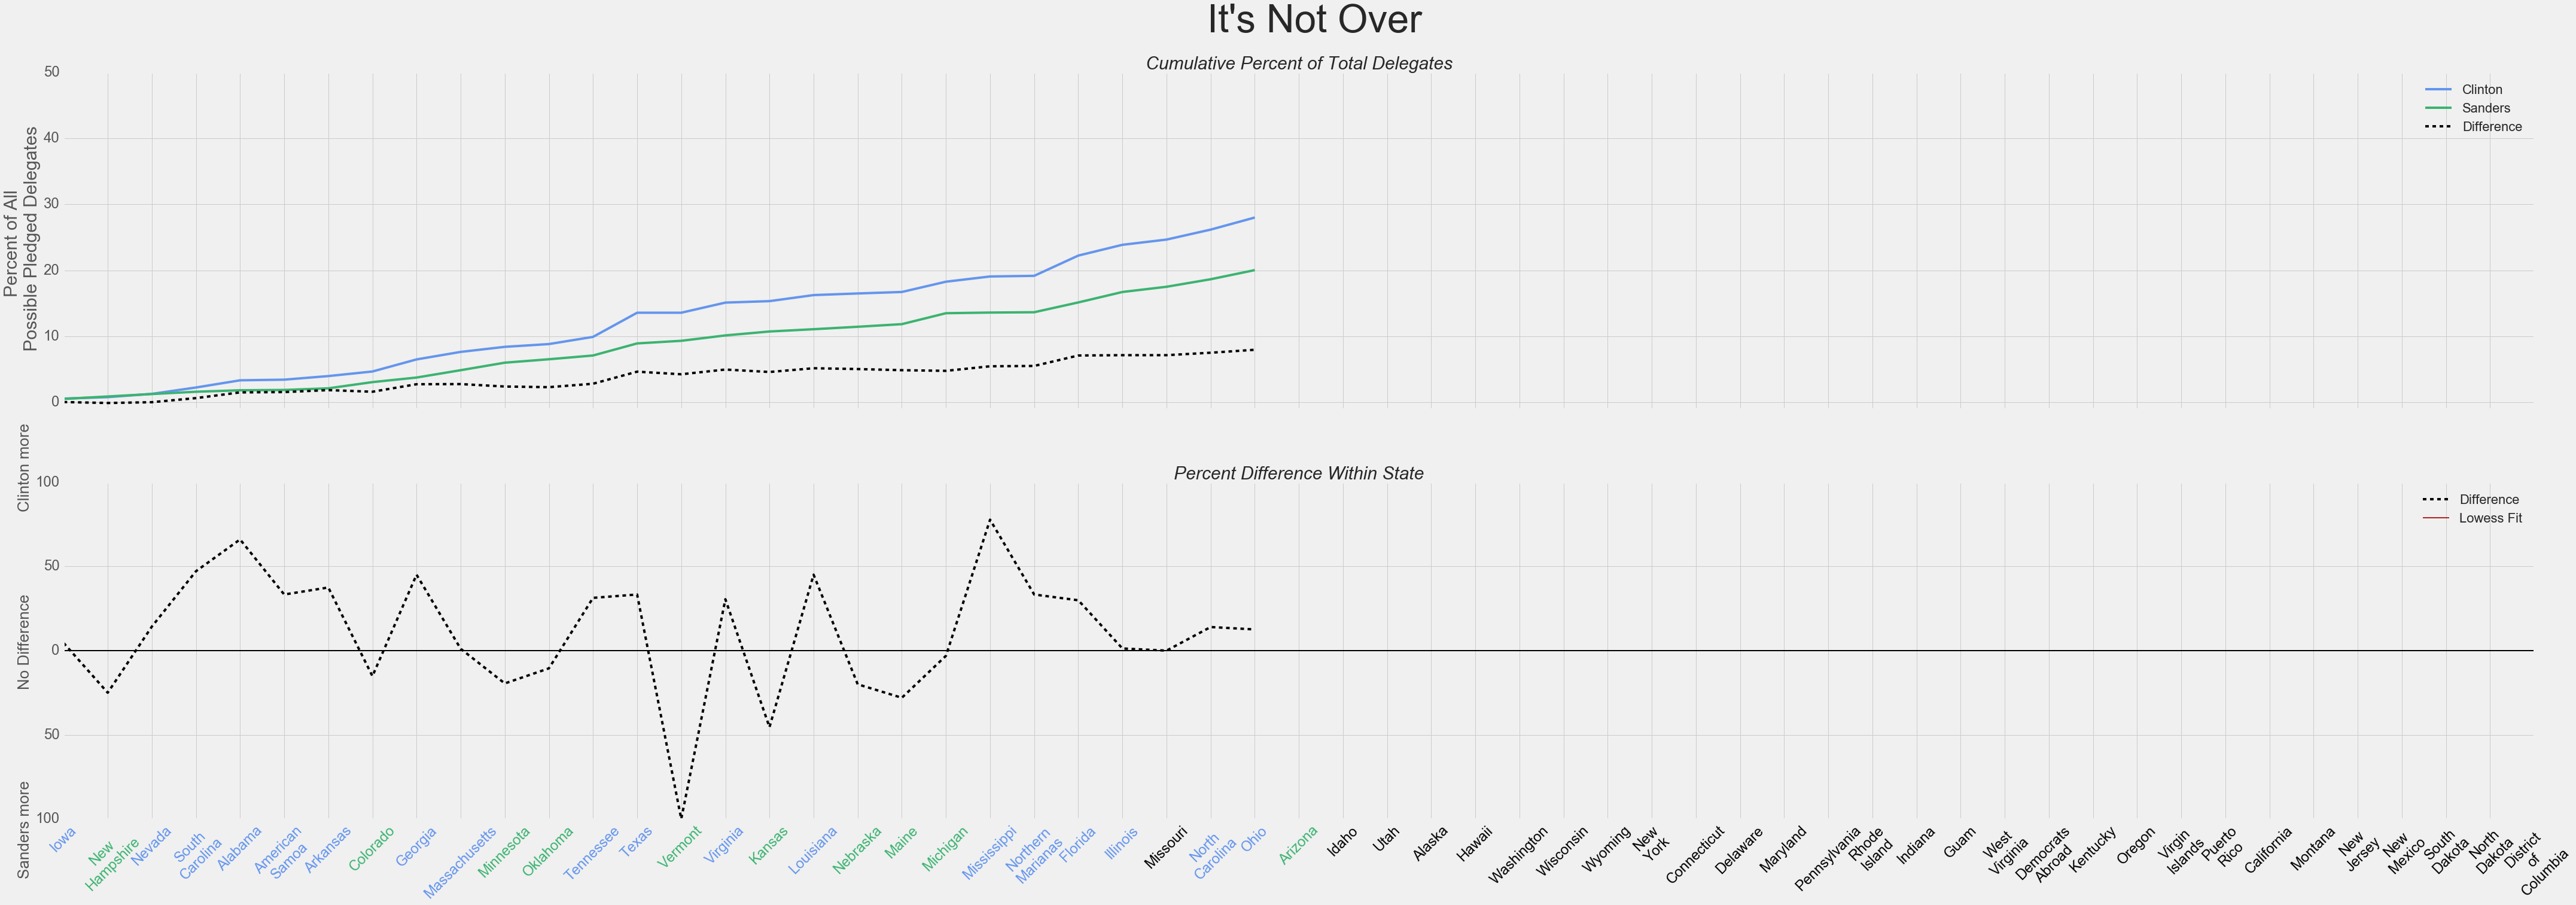

In [549]:
#toNow = D[[time.localtime() > time.strptime(elem,'%B %d %Y') for elem in D['Date']]]
toNow = D
#diffs = toNow.ix[:,'PercDiff'].values
#slope, intercept = np.polyfit(range(len(diffs)),diffs,1)
#fits = slope * np.arange(len(diffs)) + intercept
#normdiffs = toNow.ix[pd.notnull(toNow['NormPercDiff']),'NormPercDiff'].values

fig, axes = plt.subplots(2,1, figsize=(60,20),sharex=True)

axes[0].plot(toNow.index,toNow['PercClinton'],'cornflowerblue',
         toNow.index,toNow['PercSanders'],'mediumseagreen',
         toNow.index,toNow['PercDiff'],'k--', linewidth=4);
#axes[0].plot(np.arange(len(diffs)),fits,'firebrick',alpha=.6);
axes[0].yaxis.set_tick_params(labelsize=24);
axes[0].set_ylabel('Percent of All \n Possible Pledged Delegates',fontsize=30);
axes[0].set_ylim([-1,50]);
axes[0].set_xlim([0,56]);
axes[0].legend(('Clinton','Sanders','Difference','Linear Fit'),fontsize=22);
axes[0].set_title('Cumulative Percent of Total Delegates',fontsize=30,style='italic')

axes[1].plot(toNow.index,toNow['NormPercDiff'],'k--', linewidth=4);
axes[1].axhline(color='black',linewidth=2);
#sns.regplot(x=np.arange(len(diffs)),y=normdiffs,ax=axes[1],scatter=False,lowess=True,color='firebrick',line_kws={'alpha':.6,'linewidth':4})
axes[1].yaxis.set_tick_params(labelsize=24);
axes[1].set_ylabel('Sanders more \t\t\t No Difference \t\t\t Clinton more'.expandtabs(),fontsize=26);
axes[1].set_ylim([-100,100]);
axes[1].set_yticklabels([100,50,0,50,100]);
axes[1].legend(('Difference','Lowess Fit'),fontsize=22);
axes[1].get_legend().legendHandles[1].set_color('firebrick');
plt.xticks(range(len(toNow)),toNow['State'].apply(lambda x: x.replace(' ','\n')),rotation=45,fontsize=24,multialignment='center');

for i,label in enumerate(axes[1].get_xticklabels()):
    if toNow.ix[i,'NormPercDiff'] > 0:
        label.set_color('cornflowerblue')
    else:
        label.set_color('mediumseagreen')
    if i == 25 or i > 28:
        label.set_color('black')
plt.tight_layout()
axes[1].set_title('Percent Difference Within State',fontsize=30,style='italic')
plt.suptitle("     It's Not Over",fontsize=65,y=1.05,fontdict={'weight':'bold'});
plt.savefig('notOver.png',bbox_inches='tight')